In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/classicRec.png
/kaggle/input/book-recommendation-dataset/Books.csv
/kaggle/input/book-recommendation-dataset/DeepRec.png
/kaggle/input/book-recommendation-dataset/recsys_taxonomy2.png


In [59]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import models, layers, utils
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate, Dropout,Hashing,Normalization
import warnings
warnings.filterwarnings("ignore")

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
df_books= pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
df_users=pd.read_csv("/kaggle/input/book-recommendation-dataset/Users.csv")
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
df_rating=pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")
df_rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## EDA

In [94]:
print(df_books.describe(include='all'))
print(df_users.describe(include='all'))
print(df_rating.describe())

              ISBN      Book-Title      Book-Author  Year-Of-Publication  \
count       271360          271360           271358               271360   
unique      271360          242135           102022                  202   
top     0195153448  Selected Poems  Agatha Christie                 2002   
freq             1              27              632                13903   

        Publisher                                        Image-URL-S  \
count      271358                                             271360   
unique      16807                                             271044   
top     Harlequin  http://images.amazon.com/images/P/185326119X.0...   
freq         7535                                                  2   

                                              Image-URL-M  \
count                                              271360   
unique                                             271044   
top     http://images.amazon.com/images/P/185326119X.0...   
freq          

In [7]:
print(df_books.isnull().sum())
print(df_users.isnull().sum())
print(df_rating.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
User-ID          0
Location         0
Age         110762
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


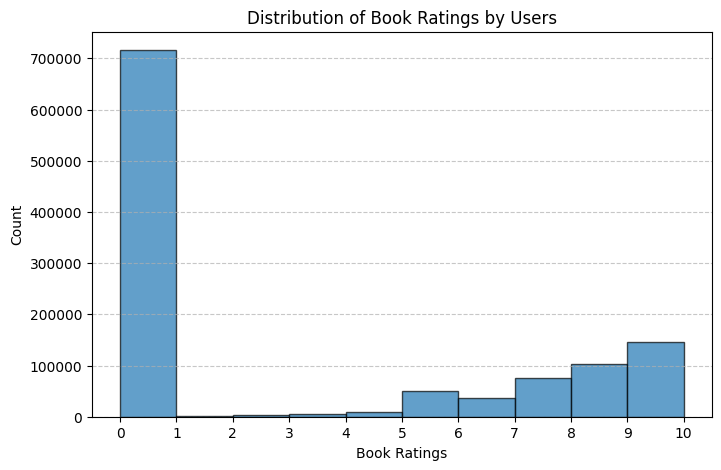

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(df_rating['Book-Rating'], bins=range(0, 11), edgecolor='black', alpha=0.7)
plt.xlabel('Book Ratings')
plt.ylabel('Count')
plt.title('Distribution of Book Ratings by Users')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


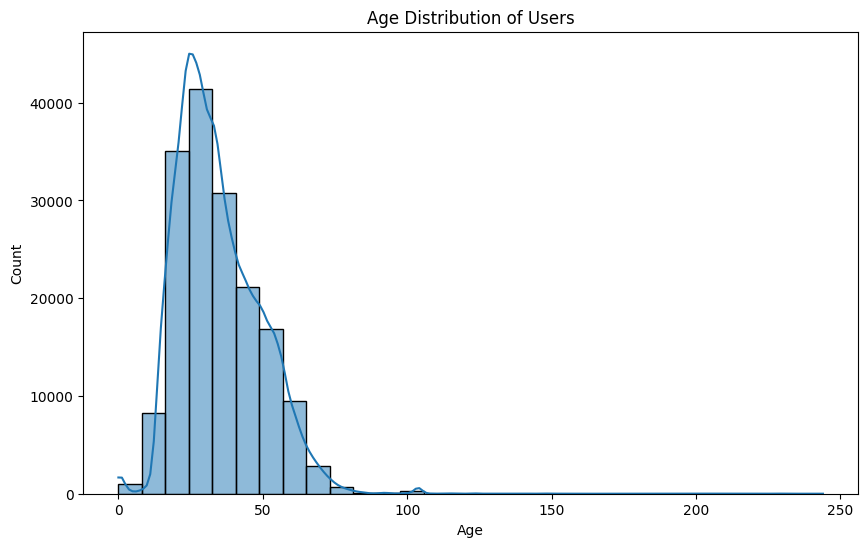

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_users['Age'], bins=30, kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Country
usa               139711
canada             21658
united kingdom     18538
germany            17043
spain              13147
australia          11784
italy              11266
                    4578
france              3455
portugal            3325
Name: count, dtype: int64


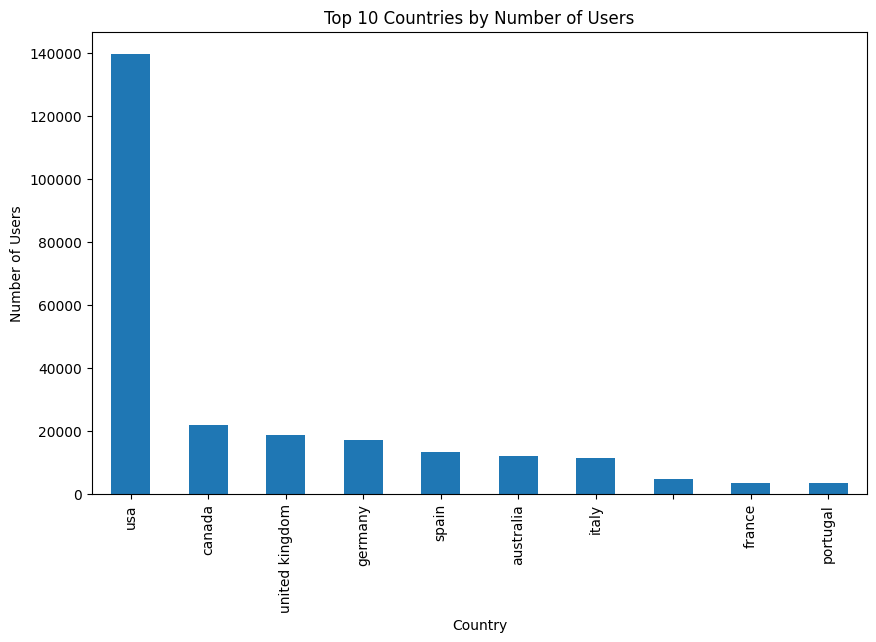

In [10]:
df_users['Country'] = df_users['Location'].apply(lambda x: x.split(',')[-1].strip())

top_countries = df_users['Country'].value_counts().head(10)
print(top_countries)

plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar')
plt.title('Top 10 Countries by Number of Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.show()

In [14]:
df_rating_books = pd.merge(df_rating, df_books, on='ISBN', how='left')
df_rating_books_users = pd.merge(df_rating_books, df_users, on='User-ID', how='left')

/tmp/ipykernel_165/2319493115.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating_age_group = df_rating_books_users.groupby('Age-Group')['Book-Rating'].mean()


Age-Group
0-18     3.649432
19-25    3.015708
26-35    2.762376
36-45    2.680697
46-55    2.951106
56-65    2.398560
65+      2.887276
Name: Book-Rating, dtype: float64


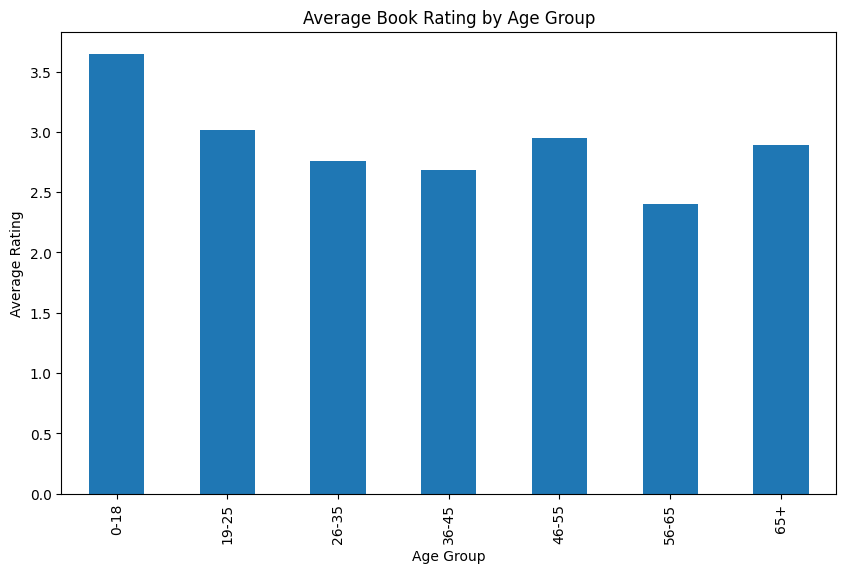

In [15]:
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']
df_rating_books_users['Age-Group'] = pd.cut(df_rating_books_users['Age'], bins=bins, labels=labels, right=False)

avg_rating_age_group = df_rating_books_users.groupby('Age-Group')['Book-Rating'].mean()
print(avg_rating_age_group)

plt.figure(figsize=(10, 6))
avg_rating_age_group.plot(kind='bar')
plt.title('Average Book Rating by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.show()

In [16]:
most_active_users = df_rating['User-ID'].value_counts().head(10)
print(most_active_users)

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: count, dtype: int64


In [17]:
top_rated_books = df_rating_books.groupby('Book-Title')['Book-Rating'].mean().sort_values(ascending=False).head(10)
print(top_rated_books)

Book-Title
Film Is: The International Free Cinema                                                                                                    10.0
More Secrets of Happy Children: Embrace Your Power as a Parent--and Help Your Children be Confident, Positive, Well-Adjusted and Happy    10.0
Jo's Boys : From the Original Publisher                                                                                                   10.0
The Vanished Priestess : An Annie Szabo Mystery                                                                                           10.0
Game and Hunting                                                                                                                          10.0
Joan Miro: 1893-1983 (Basic Series)                                                                                                       10.0
The Vampire's Apprentice                                                                                                           

In [7]:
#Some year aren't valid
df_books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [8]:
#Some age invalid
df_users['Age'].max()

244.0

## Data Cleansing and Feature Engineering

In [63]:
df_books= pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")
df_users=pd.read_csv("/kaggle/input/book-recommendation-dataset/Users.csv")
df_rating=pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")

In [64]:
#Fix Invalid Age
df_users = df_users[df_users['Age'] < 100]
df_rating = df_rating[df_rating['User-ID'].isin(df_users['User-ID'].tolist())]
#Impute missing age
df_users = df_users[df_users['Age'] < 100]
df_rating = df_rating[df_rating['User-ID'].isin(df_users['User-ID'].tolist())]
#Bucketize Age
age_bins = [0, 12, 18, 25, 35, 50, 100]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']
df_users['Age_Bucket'] = pd.cut(df_users['Age'], bins=age_bins, labels=age_labels, right=False)

#One hot encoding age bucket
df_users_ohe = pd.get_dummies(df_users, columns=['Age_Bucket'])
df_users_ohe=df_users_ohe[df_users_ohe.select_dtypes(include='bool').columns].astype(int)
df_users = pd.concat([df_users,df_users_ohe], axis=1)
df_users.drop(columns=['Age_Bucket'], inplace=True)


In [65]:
#Drop Unnecessary
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis = 1, inplace = True) 

#Fill na
df_books['Book-Author'].fillna('Unknown', inplace=True)
df_books['Publisher'].fillna('Unknown', inplace=True)

#Deal with invalid publication year
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'], errors='coerce')
valid_years_range = (1800, 2024)
df_books=df_books[df_books['Year-Of-Publication'].between(valid_years_range[0], valid_years_range[1], inclusive='both')]

#Bucketize publication year
bins = [0, 1949, 1999, 2009, float('inf')]
labels = ['Before 1950', '1950-1999', '2000-2009', '2010 and later']

df_books['Publication-Bucket'] = pd.cut(df_books['Year-Of-Publication'], bins=bins, labels=labels, right=False)
df_books.drop(columns=['Year-Of-Publication'], inplace=True)


#Encode bucket year
df_books_ohe = pd.get_dummies(df_books, columns=['Publication-Bucket'])
df_books_ohe=df_books_ohe[df_books_ohe.select_dtypes(include='bool').columns].astype(int)
df_books= pd.concat([df_books,df_books_ohe], axis=1)
df_books.drop(columns=['Publication-Bucket'], inplace=True)

In [66]:
df_rating = df_rating[df_rating['ISBN'].isin(df_books['ISBN'])]

In [67]:
print(df_books.isnull().sum())
print(df_users.isnull().sum())
print(df_rating.isnull().sum())

ISBN                                 0
Book-Title                           0
Book-Author                          0
Publisher                            0
Publication-Bucket_Before 1950       0
Publication-Bucket_1950-1999         0
Publication-Bucket_2000-2009         0
Publication-Bucket_2010 and later    0
dtype: int64
User-ID                   0
Location                  0
Age                       0
Age_Bucket_Child          0
Age_Bucket_Teen           0
Age_Bucket_Young Adult    0
Age_Bucket_Adult          0
Age_Bucket_Middle Aged    0
Age_Bucket_Senior         0
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [68]:
print("Shape of df_books:", df_books.shape)
print("Shape of df_rating:", df_rating.shape)
print("Shape of df_users:", df_users.shape)

Shape of df_books: (266725, 8)
Shape of df_rating: (739853, 3)
Shape of df_users: (167723, 9)


In [69]:
df = pd.merge(pd.merge(df_rating, df_users, on = 'User-ID'), df_books, on = 'ISBN')

df = df.rename(columns={"Book-Rating":"y"})

df.dropna(inplace = True)

## Model building

In [71]:
user_id_map = {id: idx for idx, id in enumerate(df['User-ID'].unique())}
book_id_map = {id: idx for idx, id in enumerate(df['ISBN'].unique())}
df['user_id_mapped'] = df['User-ID'].map(user_id_map)
df['book_id_mapped'] = df['ISBN'].map(book_id_map)

In [73]:
train, temp = train_test_split(df, test_size=0.2, random_state=0)

valid, test = train_test_split(temp, test_size=0.5, random_state=0)

X_train = [train['user_id_mapped'].values, train['book_id_mapped'].values,train['Book-Author'],train['Publisher'],train['Location'],train['Age']]
y_train = train['y'].values

X_valid = [valid['user_id_mapped'].values, valid['book_id_mapped'].values,valid['Book-Author'],valid['Publisher'],valid['Location'],valid['Age']]
y_valid = valid['y'].values

X_test = [test['user_id_mapped'].values, test['book_id_mapped'].values,test['Book-Author'],test['Publisher'],test['Location'],test['Age']]
y_test = test['y'].values

## Hybrid model

In [74]:
n_users = len(df['user_id_mapped'].unique())  
n_books = len(df['book_id_mapped'].unique())  
embeddings_size = 50

In [75]:
n_books_author= len(df['Book-Author'].unique())  
n_books_publisher= len(df['Book-Author'].unique()) 
n_location= len(df['Location'].unique()) 
n_bin=1000

In [78]:
#Collaborative filtering
user_input = Input(shape=(1,))
book_input = Input(shape=(1,)) 

user_embed = Embedding(n_users, embeddings_size)(user_input)  
book_embed = Embedding(n_books,embeddings_size)(book_input)

xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(user_embed )    
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(book_embed)

# Dot product
dot = layers.Dot(name='dot', normalize=True, axes=1)([xusers, xproducts])

# Content-based input layers
book_author_in = Input(shape=(1,), dtype=tf.string, name='book_author_in') 
book_publisher_in = Input(shape=(1,), dtype=tf.string, name='book_publisher_in') 
location_in = Input(shape=(1,), dtype=tf.string, name='location_in') 

# Hashing layers for content-based features
book_author_hash = Hashing(num_bins=n_bin, name='book_author_hash')(book_author_in)
book_publisher_hash = Hashing(num_bins=n_bin, name='book_publisher_hash')(book_publisher_in)
location_hash = Hashing(num_bins=n_bin, name='location_hash')(location_in)

# Embedding layers for content-based features
book_author_embedd = Embedding(n_books_author, embeddings_size, name='book_author_embedd')(book_author_hash)
book_publisher_embedd = Embedding(n_books_publisher, embeddings_size, name='book_publisher_embedd')(book_publisher_hash)
location_embedd = Embedding(n_books_author, embeddings_size, name='location_embedd')(location_hash)

# Reshape layers for content-based embeddings
book_author_embedd_x = layers.Reshape(name='book_author_embedd_x', target_shape=(embeddings_size,))(book_author_embedd)
book_publisher_embedd_x =layers.Reshape(name='book_publisher_embedd_x', target_shape=(embeddings_size,))(book_publisher_embedd)
location_embedd_x =layers.Reshape(name='location_embedd_x', target_shape=(embeddings_size,))(location_embedd)

# User age input and normalization
user_age_in = Input(shape=(1,), name='user_age_in')
user_age_norm = Normalization(name='user_age_norm')(user_age_in)

#Concat
out = layers.Concatenate()([dot, book_author_embedd_x, book_publisher_embedd_x,location_embedd_x,user_age_norm ])

# Dense layers 
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
dropout2 = Dropout(0.4)(dense2)
dense3 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dropout2)
output = Dense(1)(dense3)            


model = Model(inputs = [user_input, book_input,book_author_in,book_publisher_in,location_in,user_age_in], 
              outputs = output)
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

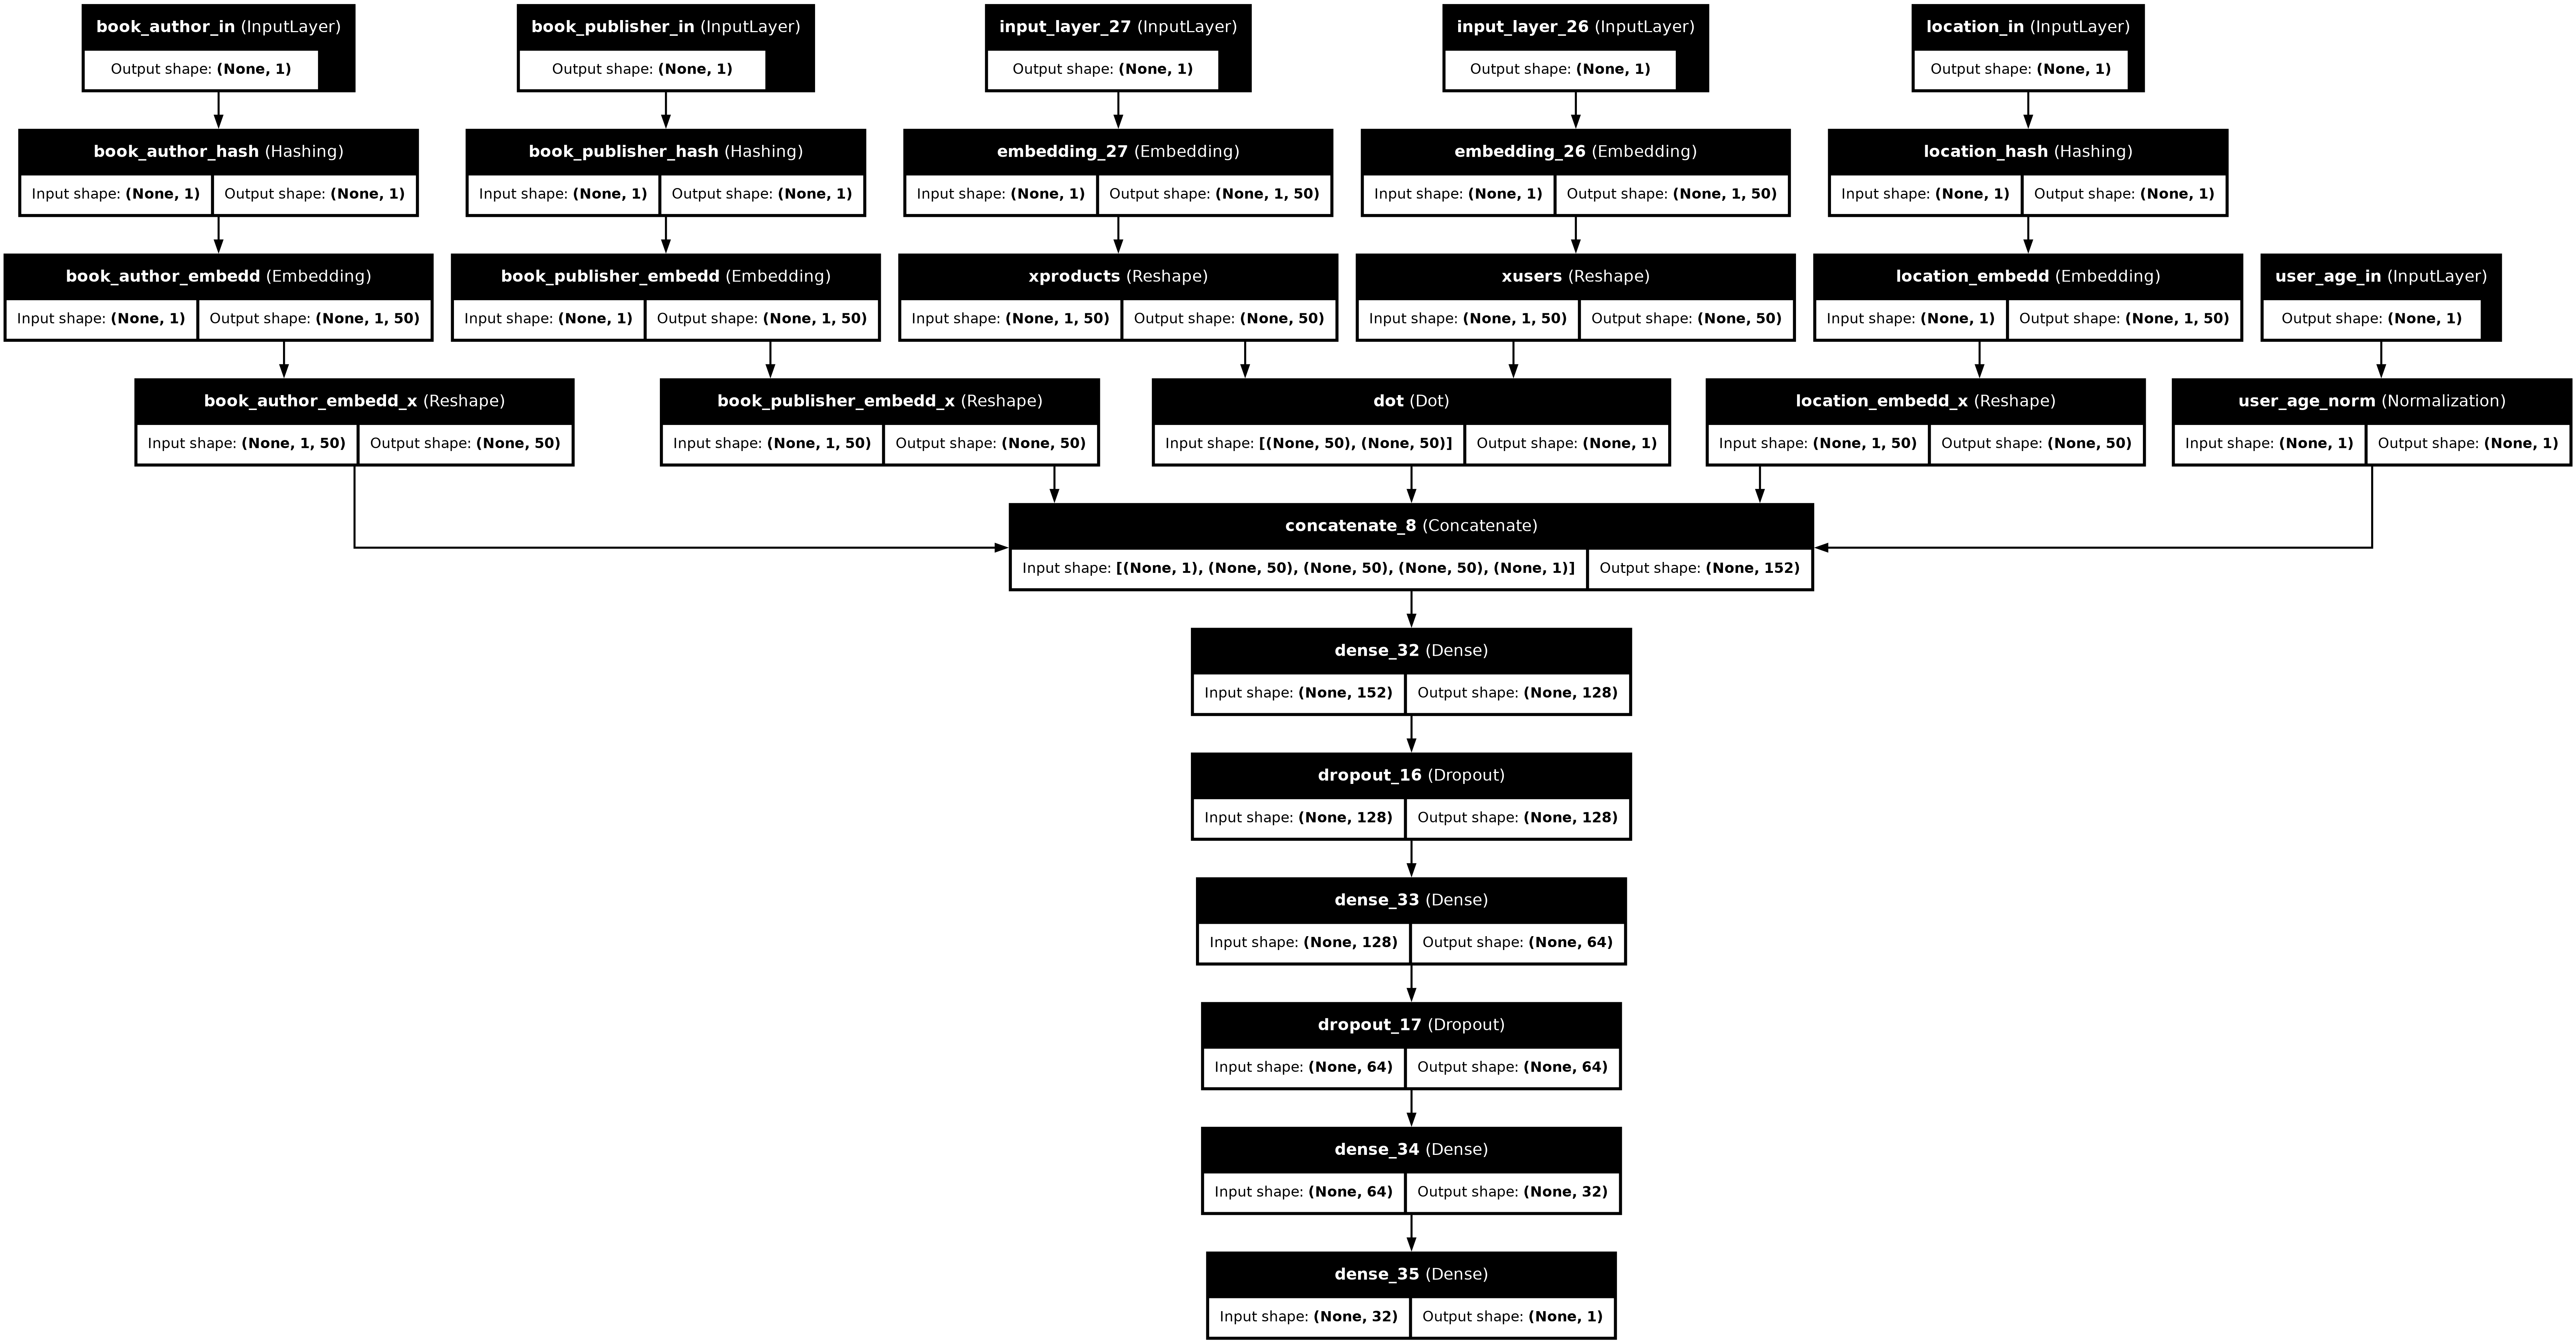

In [79]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [80]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('rec.keras', save_best_only=True, monitor='val_loss')

In [85]:
training =model.fit(x=X_train, y=y_train, epochs=10, batch_size=512, 
                    verbose=1, 
                    validation_data=(X_valid, y_valid),
                   callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 190s 164ms/step - loss: 4.2438 - val_loss: 17.9224
Epoch 2/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 197s 170ms/step - loss: 2.0921 - val_loss: 17.9346
Epoch 3/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 194s 167ms/step - loss: 1.8106 - val_loss: 19.2891


# Evaluation

In [82]:
def plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

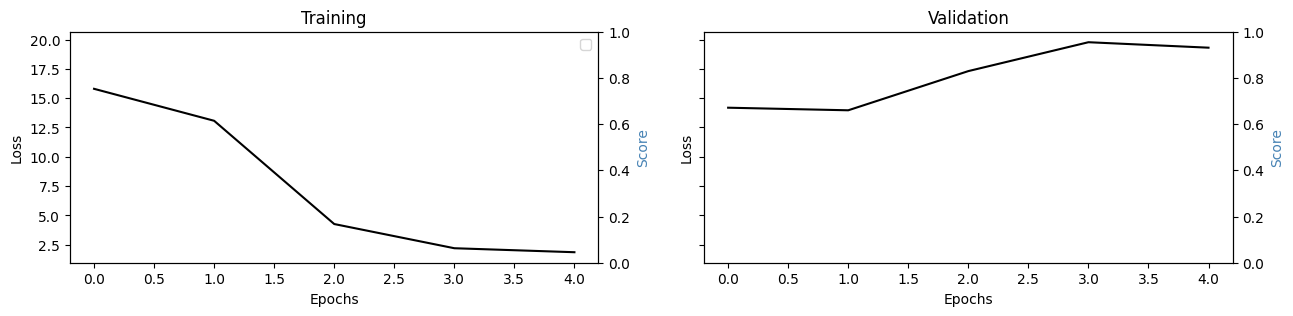

In [83]:
plot_keras_training(training)

In [90]:
loss = model.evaluate(X_test, y_test)
print(loss)

2313/2313 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 18.0778
17.977392196655273


In [192]:
def recommend(user_id, model, df, n_recomend=5):
    
    """
    Recommends books to a user based on collaborative filtering using a trained model.

    Parameters:
        user_id (int): The user ID for whom recommendations are to be generated.-->user_id_mapped column
        model: The trained collaborative filtering model capable of predicting user-book ratings.
        df (DataFrame): The DataFrame containing user-book interactions and metadata.
        n_recommend (int, optional): The number of books to recommend. Default is 5.

    Returns:
        DataFrame: A DataFrame containing recommended books sorted by predicted ratings.

    """
    
    length = len(df['user_id_mapped'])
    user_ids = np.full(length, user_id)
    
    age=df[df['user_id_mapped']==user_id]['Age'].values[0]
    user_age = np.array([age] * len(df['book_id_mapped']))
    print("User ID:", user_id)
    print("User Age:", age)
    
    ratings = model.predict([[user_ids, df['book_id_mapped'].values,df['Book-Author'],df['Publisher'],df['Location'],df['Age']]])
    
    recommend_df = pd.DataFrame({
    'book_id_mapped': df['book_id_mapped'],
    'Book-Title': df['Book-Title'],
    'ISBN': df['ISBN'],
    'Predicted_Rating': ratings.flatten()})
    
    recommend_df = recommend_df.drop_duplicates(subset=['Book-Title'])
    
    recommend_df = recommend_df.sort_values(by='Predicted_Rating', ascending = False)
    
    return recommend_df.head(n_recomend)

In [193]:
recommend(5, model, df, n_recomend=5)

User ID: 5
User Age: 19.0
23121/23121 ━━━━━━━━━━━━━━━━━━━━ 540s 23ms/step


,book_id_mapped,Book-Title,ISBN,Predicted_Rating
250070,113171,Going Postal : A Novel of Discworld (Pratchett...,0060013133,8.779766
255735,116267,Killing Neptune's Daughter,1890768618,8.754253
255734,116266,Competition Can Be Murder: A Charlie Parker My...,1890768596,8.751952
252662,114565,Kingdom of Cages,0446524913,8.743423
251708,114125,The Stone Prince (Hqn Books),0373770073,8.730704
